### Introduction to Keras and TensorFlow

In the previous chapter, you already had a first light contact with some of the corresponding TensorFlow and Keras APIs: you’ve briefly used TensorFlow’s Variable class, the matmul operation, and the GradientTape. You’ve instantiated Keras Dense layers, packed them into a Sequential model, and trained that model with the fit() method. <br>
Now let’s take a deeper dive into how all of these different concepts can be approached in practice using TensorFlow and Keras.

### First steps with TensorFlow
#### Constant tensors and variables
To do anything in TensorFlow, we’re going to need some tensors. Tensors need to be created with some initial value. For instance, you could create all-ones or all-zeros tensors or tensors of values drawn from a random distribution.

##### All-ones or all-zeros tensors

In [2]:
import tensorflow as tf

x = tf.ones(shape=(2, 1)) # Equivalent to np.ones(shape=(2, 1))
print(x)

tf.Tensor(
[[1.]
 [1.]], shape=(2, 1), dtype=float32)


In [3]:
x = tf.zeros(shape=(2, 1)) # Equivalent to np.zeros(shape=(2, 1))
print(x)

tf.Tensor(
[[0.]
 [0.]], shape=(2, 1), dtype=float32)


##### Random tensors

In [4]:
x = tf.random.normal(shape=(3, 1), mean=0., stddev=1.) # Equivalent to np.random.normal(size=(3, 1), loc=0., scale=1.).
# Tensor of random values drawn from a normal distribution with mean 0 and standard deviation 1.
print(x)

tf.Tensor(
[[-1.785639  ]
 [-0.6084251 ]
 [ 0.76205087]], shape=(3, 1), dtype=float32)


In [5]:
x = tf.random.uniform(shape=(3, 1), minval=0., maxval=1.) # Equivalent to np.random.uniform(size=(3, 1), low=0., high=1.).
# Tensor of random values drawn from a uniform distribution between 0 and 1.
print(x)

tf.Tensor(
[[0.24118769]
 [0.5413426 ]
 [0.38954782]], shape=(3, 1), dtype=float32)


##### NumPy arrays are assignable
A significant difference between NumPy arrays and TensorFlow tensors is that **TensorFlow tensors aren’t assignable: they’re constant.** <br>
For instance, in NumPy, you can do the following.

In [6]:
import numpy as np

x = np.ones(shape=(2, 2))
x[0, 0] = 0.

##### TensorFlow tensors are not assignable
Try to do the same thing in TensorFlow, and you will get an error: “EagerTensor object does not support item assignment.”

In [7]:
x = tf.ones(shape=(2, 2))
x[0, 0] = 0.

TypeError: 'tensorflow.python.framework.ops.EagerTensor' object does not support item assignment

##### Creating a TensorFlow variable
To train a model, we’ll need to update its state, which is a set of tensors. If tensors aren’t assignable, how do we do it? <br>
That’s where **variables** come in. <br>
**tf.Variable** is the class meant to manage modifiable state in TensorFlow. You’ve already briefly seen it in action in the training loop implementation at the end of chapter 2. <br>
To create a variable, you need to provide some initial value, such as a random tensor.

In [8]:
v = tf.Variable(initial_value=tf.random.normal(shape=(3, 1)))
print(v)

<tf.Variable 'Variable:0' shape=(3, 1) dtype=float32, numpy=
array([[-0.0419495 ],
       [ 1.1424781 ],
       [-0.32543883]], dtype=float32)>


##### Assigning a value to a TensorFlow variable
The state of a variable can be modified via its assign method, as follows.

In [9]:
v.assign(tf.ones(shape=(3, 1)))

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[1.],
       [1.],
       [1.]], dtype=float32)>

##### Assigning a value to a subset of a TensorFlow variable
It also works for a subset of the coefficients.

In [10]:
v[0, 0].assign(3.)

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[3.],
       [1.],
       [1.]], dtype=float32)>

##### Using assign_add()
Similarly, **assign_add()** and **assign_sub()** are efficient equivalents of **+=** and **-=**, as shown next.

In [11]:
v.assign_add(tf.ones(shape=(3, 1)))

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[4.],
       [2.],
       [2.]], dtype=float32)>

#### Tensor operations: Doing math in TensorFlow
Just like NumPy, TensorFlow offers a large collection of tensor operations to express mathematical formulas. <br>
Here are a few examples.
##### A few basic math operations

In [12]:
a = tf.ones((2, 2))
b = tf.square(a) # Take the square.
c = tf.sqrt(a) # Take the square root.
d = b + c # Add two tensors (element-wise).
e = tf.matmul(a, b) # Take the product of two tensors(Multiply two matrices).
e *= d # Multiply two tensors (element-wise).

Importantly, each of the preceding operations gets executed on the fly: at any point, you can print what the current result is, just like in NumPy. <br>
We call this **eager execution**.

#### A second look at the GradientTape API
So far, TensorFlow seems to look a lot like NumPy. But here’s something NumPy can’t do: retrieve the gradient of any differentiable expression with respect to any of its inputs. <br>
Just open a **GradientTape** scope, apply some computation to one or several input tensors, and retrieve the gradient of the result with respect to the inputs.

##### Using the GradientTape

In [13]:
input_var = tf.Variable(initial_value=3.)
with tf.GradientTape() as tape:
    result = tf.square(input_var)
gradient = tape.gradient(result, input_var)

##### Using GradientTape with constant tensor inputs
This is most commonly used to retrieve the gradients of the loss of a model with respect to its weights: gradients = tape.gradient(loss, weights). You saw this in action in chapter 2. <br>
So far, you’ve only seen the case where the input tensors in tape.gradient() were TensorFlow variables. It’s actually possible for these inputs to be any arbitrary tensor. <br>
However, only **trainable variables** are tracked by default. With a constant tensor, you’d have to manually mark it as being tracked by calling **tape.watch()** on it.

In [14]:
input_const = tf.constant(3.)
with tf.GradientTape() as tape:
   tape.watch(input_const)
   result = tf.square(input_const)
gradient = tape.gradient(result, input_const)

##### Using nested gradient tapes to compute second-order gradients
Why is this necessary? Because it would be too expensive to preemptively store the information required to compute the gradient of anything with respect to anything. To avoid wasting resources, the tape needs to know what to watch. Trainable variables are watched by default because computing the gradient of a loss with regard to a list of trainable variables is the most common use of the gradient tape. The gradient tape is a powerful utility, even capable of computing second-order gradients, that is to say, the gradient of a gradient. For instance, the gradient of the position of an object with regard to time is the speed of that object, and the second-order gradient is its acceleration. <br>
If you measure the position of a falling apple along a vertical axis over time and find that it verifies position(time) = 4.9 * time ** 2, what is its acceleration?

Let’s use two nested gradient tapes to find out.

In [16]:
time = tf.Variable(0.)
with tf.GradientTape() as outer_tape:
    with tf.GradientTape() as inner_tape:
        position =  4.9 * time ** 2
    speed = inner_tape.gradient(position, time)
acceleration = outer_tape.gradient(speed, time)
# We use the outer tape to compute the gradient of the gradient from the inner tape. 
# Naturally, the answer is 4.9 * 2 = 9.8.

#### An end-to-end example: A linear classifier in pure TensorFlow
You know about tensors, variables, and tensor operations, and you know how to compute gradients. That’s enough to build any machine learning model based on gradient descent. And you’re only at chapter 3! <br>
In a machine learning job interview, you may be asked to implement a linear classifier from scratch in TensorFlow: a very simple task that serves as a filter between candidates who have some minimal machine learning background and those who don’t. <br>
Let’s get you past that filter and use your newfound knowledge of TensorFlow to implement such a linear classifier.

First, let’s come up with some nicely linearly separable synthetic data to work with: two classes of points in a 2D plane. We’ll generate each class of points by drawing their coordinates from a random distribution with a specific covariance matrix and a specific mean. Intuitively, the covariance matrix describes the shape of the point cloud, and the mean describes its position in the plane (see figure 3.6 . We’ll reuse the same covariance matrix for both point clouds, but we’ll use two different mean values—the point clouds will have the same shape, but different positions.

##### Generating two classes of random points in a 2D plane

In [18]:
num_samples_per_class = 1000
negative_samples = np.random.multivariate_normal(
    mean=[0, 3],
    cov=[[1, 0.5],[0.5, 1]],
    size=num_samples_per_class)
# Generate the first class of points: 1000 random 2D points. cov=[[1, 0.5],[0.5, 1]] corresponds to an oval-like point cloud oriented from bottom left to top right.

positive_samples = np.random.multivariate_normal(
    mean=[3, 0],
    cov=[[1, 0.5],[0.5, 1]],
    size=num_samples_per_class)
# Generate the other class of points with a different mean and the same covariance matrix.

##### Stacking the two classes into an array with shape (2000, 2)
In the preceding code, negative_samples and positive_samples are both arrays with shape (1000, 2). Let’s stack them into a single array with shape (2000, 2).

In [19]:
inputs = np.vstack((negative_samples, positive_samples)).astype(np.float32)

##### Generating the corresponding targets (0 and 1)
Let’s generate the corresponding target labels, an array of zeros and ones of shape (2000, 1), where targets[i, 0] is 0 if inputs[i] belongs to class 0 (and inversely).

In [20]:
targets = np.vstack((np.zeros((num_samples_per_class, 1), dtype="float32"),
                     np.ones((num_samples_per_class, 1), dtype="float32")))

##### Plotting the two point classes (see figure 3.6)
Next, let’s plot our data with Matplotlib.

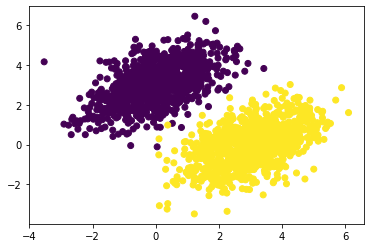

In [22]:
import matplotlib.pyplot as plt

plt.scatter(inputs[:, 0], inputs[:, 1], c=targets[:, 0])
plt.show()

##### Creating the linear classifier variables
Now let’s create a linear classifier that can learn to separate these two blobs. A linear classifier is an affine transformation (prediction = W • input + b) trained to minimize the square of the difference between predictions and the targets. <br>
As you’ll see, it’s actually a much simpler example than the end-to-end example of a toy two-layer neural network you saw at the end of chapter 2. However, this time you should be able to understand everything about the code, line by line.

Let’s create our variables, W and b, initialized with random values and with zeros,
respectively.

In [24]:
input_dim = 2 # The inputs will be 2D points.
output_dim = 1 # The output predictions will be a single score per sample (close to 0 if the sample is predicted to be in class 0, and close to 1 if the sample is predicted to be in class 1).
W = tf.Variable(initial_value=tf.random.uniform(shape=(input_dim, output_dim)))
b = tf.Variable(initial_value=tf.zeros(shape=(output_dim,)))

##### The forward pass function
Here’s our forward pass function.

In [25]:
def model(inputs):
    return tf.matmul(inputs, W) + b

##### The mean squared error loss function
Because our linear classifier operates on 2D inputs, W is really just two scalar coefficients, w1 and w2: W = [[w1], [w2]]. Meanwhile, b is a single scalar coefficient. <br>
As such, for a given input point [x, y], its prediction value is prediction = [[w1], [w2]] • [x, y] + b = w1 * x + w2 * y + b.

In [26]:
def square_loss(targets, predictions):
    per_sample_losses = tf.square(targets - predictions)
    return tf.reduce_mean(per_sample_losses)

##### The training step function
Next is the training step, which receives some training data and updates the weights W and b so as to minimize the loss on the data.

In [27]:
learning_rate = 0.1

def training_step(inputs, targets):
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        loss = square_loss(targets, predictions)
    grad_loss_wrt_W, grad_loss_wrt_b = tape.gradient(loss, [W, b])
    W.assign_sub(grad_loss_wrt_W * learning_rate)
    b.assign_sub(grad_loss_wrt_b * learning_rate)
    return loss

##### The batch training loop
For simplicity, we’ll do **batch training** instead of **mini-batch training**: we’ll run each training step (gradient computation and weight update) for all the data, rather than iterate over the data in small batches. On one hand, this means that each training step will take much longer to run, since we’ll compute the forward pass and the gradients for 2,000 samples at once. On the other hand, each gradient update will be much more effective at reducing the loss on the training data, since it will encompass information from all training samples instead of, say, only 128 random samples. <br>
As a result, we will need many fewer steps of training, and we should use a larger learning rate than we would typically use for mini-batch training.(we’ll use learning_rate = 0.1)

In [28]:
for step in range(40):
    loss = training_step(inputs, targets)
    print(f"Loss at step {step}: {loss:.4f}")

Loss at step 0: 1.8869
Loss at step 1: 0.1586
Loss at step 2: 0.1045
Loss at step 3: 0.0922
Loss at step 4: 0.0857
Loss at step 5: 0.0803
Loss at step 6: 0.0755
Loss at step 7: 0.0711
Loss at step 8: 0.0671
Loss at step 9: 0.0634
Loss at step 10: 0.0600
Loss at step 11: 0.0570
Loss at step 12: 0.0542
Loss at step 13: 0.0516
Loss at step 14: 0.0493
Loss at step 15: 0.0472
Loss at step 16: 0.0452
Loss at step 17: 0.0434
Loss at step 18: 0.0418
Loss at step 19: 0.0403
Loss at step 20: 0.0390
Loss at step 21: 0.0377
Loss at step 22: 0.0366
Loss at step 23: 0.0356
Loss at step 24: 0.0346
Loss at step 25: 0.0337
Loss at step 26: 0.0330
Loss at step 27: 0.0322
Loss at step 28: 0.0316
Loss at step 29: 0.0310
Loss at step 30: 0.0304
Loss at step 31: 0.0299
Loss at step 32: 0.0295
Loss at step 33: 0.0291
Loss at step 34: 0.0287
Loss at step 35: 0.0283
Loss at step 36: 0.0280
Loss at step 37: 0.0277
Loss at step 38: 0.0275
Loss at step 39: 0.0272


After 40 steps, the training loss seems to have stabilized around 0.025. Let’s plot how our linear model classifies the training data points. Because our targets are zeros and ones, a given input point will be classified as “0” if its prediction value is below 0.5, and as “1” if it is above 0.5.

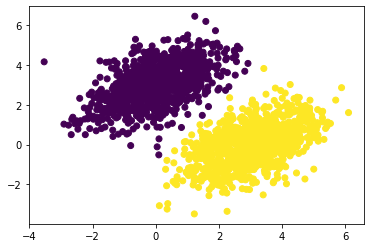

In [29]:
predictions = model(inputs)
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)
plt.show()

Recall that the prediction value for a given point [x, y] is simply prediction == [[w1], [w2]] • [x, y] + b == w1 * x + w2 * y + b. Thus, class 0 is defined as w1 * x + w2 * y + b < 0.5, and class 1 is defined as w1 * x + w2 * y + b > 0.5. You’ll notice that what you’re looking at is really the equation of a line in the 2D plane: w1 * x + w2 * y + b = 0.5. <br>
Above the line is class 1, and below the line is class 0. You may be used to seeing line equations in the format y = a * x + b; in the same format, our line becomes y = - w1 / w2 * x + (0.5 - b) / w2.

Let’s plot this line

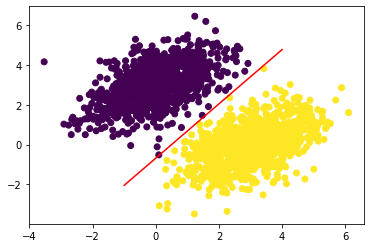

In [31]:
x = np.linspace(-1, 4, 100) # Generate 100 regularly spaced numbers between –1 and 4, which we will use to plot our line.
y = - W[0] /  W[1] * x + (0.5 - b) / W[1] # This is our line’s equation.
plt.plot(x, y, "-r") # Plot our line ("-r" means “plot it as a red line”).
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5) # Plot our model’s predictions on the same plot.

This is really what a linear classifier is all about: finding the parameters of a line (or, in higher-dimensional spaces, a hyperplane) neatly separating two classes of data.

### Anatomy of a neural network: Understanding core Keras APIs
#### Layers: The building blocks of deep learning
The fundamental data structure in neural networks is the layer, to which you were introduced in chapter 2. 
- A layer is a data processing module that takes as input one or more tensors and that outputs one or more tensors. 
- Some layers are stateless, but more frequently layers have a state: the layer’s weights, one or several tensors learned with stochastic gradient descent, which together contain the network’s knowledge.
- Different types of layers are appropriate for different tensor formats and different types of data processing. 
- For instance, **simple vector data, stored in rank-2 tensors of shape (samples, features), is often processed by densely connected layers, also called fully connected or dense layers (the Dense class in Keras).**
- **Sequence data, stored in rank-3 tensors of shape (samples, timesteps, features), is typically processed by recurrent layers, such as an LSTM layer, or 1D convolution layers (Conv1D).**
- **Image data, stored in rank-4 tensors, is usually processed by 2D convolution layers (Conv2D).**

You can think of layers as the LEGO bricks of deep learning, a metaphor that is made explicit by Keras. Building deep learning models in Keras is done by clipping together compatible layers to form useful data-transformation pipelines.

##### THE BASE LAYER CLASS IN KERAS
A simple API should have a single abstraction around which everything is centered. In Keras, that’s the Layer class. Everything in Keras is either a Layer or something that closely interacts with a Layer. <br>
A Layer is an object that encapsulates some state (weights) and some computation (a forward pass). The weights are typically defined in a build() (although they could also be created in the constructor, __init__()), and the computation is defined in the call() method. <br>
In the previous chapter, we implemented a NaiveDense class that contained two weights W and b and applied the computation output = activation(dot(input, W) + b). This is what the same layer would look like in Keras.

##### A Dense layer implemented as a Layer subclass

In [34]:
from tensorflow import keras

class SimpleDense(keras.layers.Layer): # All Keras layers inherit from the base Layer class.

    def __init__(self, units, activation=None):
        super().__init__()
        self.units = units
        self.activation = activation
    
    def build(self, input_shape): # Weight creation takes place in the build() method.
        input_dim = input_shape[-1]
        self.W = self.add_weight(shape=(input_dim, self.units), initializer="random_normal")
        self.b = self.add_weight(shape=(self.units,), initializer="zeros")
        # add_weight() is a shortcut method for creating weights.
        # It is also possible to create standalone variables and assign them as layer attributes, like self.W = tf.Variable(tf.random.uniform(w_shape)).
    
    def call(self, inputs): # We define the forward pass computation in the call() method.
        y = tf.matmul(inputs, self.W) + self.b
        if self.activation is not None:
            y = self.activation(y)
        return y

Once instantiated, a layer like this can be used just like a function, taking as input a TensorFlow tensor:

In [36]:
my_dense = SimpleDense(units=32, activation=tf.nn.relu) # Instantiate our layer, defined previously.
input_tensor = tf.ones(shape=(2, 784)) # Create some test inputs.
output_tensor = my_dense(input_tensor) # Call the layer on the inputs, just like a function.
print(output_tensor.shape)

(2, 32)


You’re probably wondering, why did we have to implement call() and build(), since we ended up using our layer by plainly calling it, that is to say, by using its __call__() method? It’s because we want to be able to create the state just in time. Let’s see how that works.
##### AUTOMATIC SHAPE INFERENCE: BUILDING LAYERS ON THE FLY
Just like with LEGO bricks, you can only “clip” together layers that are compatible. <br>
The notion of layer compatibility here refers specifically to the fact that every layer will only accept input tensors of a certain shape and will return output tensors of a certain shape. 

Consider the following example:

In [38]:
from tensorflow.keras import layers

layer = layers.Dense(units=32, activation="relu") # A dense layer with 32 output units

This layer will return a tensor where the first dimension has been transformed to be 32. It can only be connected to a downstream layer that expects 32-dimensional vectors as its input. <br>
When using Keras, you don’t have to worry about size compatibility most of the time, because the layers you add to your models are dynamically built to match the shape of the incoming layer. 

For instance, suppose you write the following:

In [39]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential([
    layers.Dense(32, activation="relu"),
    layers.Dense(32)
])

The layers didn’t receive any information about the shape of their inputs—instead, they automatically inferred their input shape as being the shape of the first inputs they see. <br>
With automatic shape inference, our previous example becomes simple and neat:

In [40]:
model = keras.Sequential([
    SimpleDense(32, activation="relu"),
    SimpleDense(64, activation="relu"),
    SimpleDense(32, activation="relu"),
    SimpleDense(10, activation="softmax")
])

#### From layers to models
A deep learning model is a graph of layers. In Keras, that’s the **Model** class. Until now, you’ve only seen **Sequential** models (a subclass of Model), which are simple stacks of layers, mapping a single input to a single output. But as you move forward, you’ll be exposed to a much broader variety of network topologies. These are some common ones:
- Two-branch networks
- Multihead networks
- Residual connections

There are generally two ways of building such models in Keras: you could directly subclass the Model class, or you could use the Functional API, which lets you do more with less code. We’ll cover both approaches in chapter 7. <br>

##### The “compile” step: Configuring the learning process
Once the model architecture is defined, you still have to choose three more things:
- **Loss function (objective function)**—The quantity that will be minimized during training. It represents a measure of success for the task at hand.
- **Optimizer**—Determines how the network will be updated based on the loss function. It implements a specific variant of stochastic gradient descent (SGD).
- **Metrics**—The measures of success you want to monitor during training and validation, such as classification accuracy. Unlike the loss, training will not optimize directly for these metrics. As such, metrics don’t need to be differentiable.

Once you’ve picked your loss, optimizer, and metrics, you can use the built-in **compile()** and **fit()** methods to start training your model. Alternatively, you could also write your own custom training loops—we’ll cover how to do this in chapter 7. It’s a lot more work! <br>
For now, let’s take a look at **compile()** and **fit()**. <br>
The **compile()** method configures the training process—you’ve already been introduced to it in your very first neural network example in chapter 2. It takes the arguments **optimizer**, **loss**, and **metrics** (a list):

In [41]:
model = keras.Sequential([keras.layers.Dense(1)]) # Define a linear classifier.
model.compile(optimizer="rmsprop", # Specify the optimizer by name: RMSprop (it’s case-insensitive).
              loss="mean_squared_error", # Specify the loss function by name: mean squared error.
              metrics=["accuracy"]) # Specify a list of metrics: in this case, only accuracy.

In the preceding call to **compile()**, we passed the optimizer, loss, and metrics as
strings (such as "rmsprop"). <br>
These strings are actually shortcuts that get converted to Python objects. <br>
For instance, "rmsprop" becomes keras.optimizers.RMSprop(). <br>
Importantly, it’s also possible to specify these arguments as object instances, like this:

In [42]:
model.compile(optimizer=keras.optimizers.RMSprop(),
              loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.BinaryAccuracy()])

This is useful if you want to pass your own custom losses or metrics, or if you want to further configure the objects you’re using—for instance, by passing a **learning_rate** argument to the optimizer:
```python
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1e-4),
loss=my_custom_loss,
metrics=[my_custom_metric_1, my_custom_metric_2])
```

In chapter 7, we’ll cover how to create custom losses and metrics. In general, you won’t have to create your own losses, metrics, or optimizers from scratch, because Keras offers a wide range of built-in options that is likely to include what you need: <br>
**Optimizers**:
- SGD (with or without momentum)
- RMSprop
- Adam
- Adagrad
- Etc.

**Losses**:
- CategoricalCrossentropy
- SparseCategoricalCrossentropy
- BinaryCrossentropy
- MeanSquaredError
- KLDivergence
- CosineSimilarity
- Etc.

**Metrics**:
- CategoricalAccuracy
- SparseCategoricalAccuracy
- BinaryAccuracy
- AUC
- Precision
- Recall
- Etc.

Throughout this book, you’ll see concrete applications of many of these options.

##### Picking a loss function
**Choosing the right loss function for the right problem is extremely important**: your network will take any shortcut it can to minimize the loss, so if the objective doesn’t fully correlate with success for the task at hand, your network will end up doing things you may not have wanted. <br>
Imagine a stupid, omnipotent AI trained via SGD with this poorly chosen objective function: “maximizing the average well-being of all humans alive.” To make its job easier, this AI might choose to kill all humans except a few and focus on the well-being of the remaining ones—because average well-being isn’t affected by how many humans are left. That might not be what you intended! <br>
Just remember that all neural networks you build will be just as ruthless in lowering their loss function—so choose the objective wisely, or you’ll have to face unintended side effects.

Fortunately, when it comes to common problems such as classification, regression, and sequence prediction, there are simple guidelines you can follow to choose the correct loss. <br>
For instance, you’ll use **binary crossentropy for a two-class classification problem**, **categorical crossentropy for a many-class classification problem**, and so on. <br>
Only when you’re working on truly new research problems will you have to develop your own loss functions. In the next few chapters, we’ll detail explicitly which loss functions to choose for a wide range of common tasks.

##### Understanding the fit() method
After **compile()** comes **fit()**. <br>
The **fit()** method implements the training loop itself. <br>
These are its key arguments:
- **The data (inputs and targets)** to train on. It will typically be passed either in the form of NumPy arrays or a TensorFlow **Dataset** object. You’ll learn more about the **Dataset** API in the next chapters.
- The number of **epochs** to train for: how many times the training loop should iterate over the data passed.
- The **batch size** to use within each epoch of mini-batch gradient descent: the number of training examples considered to compute the gradients for one weight update step.

##### Calling fit() with NumPy data

In [43]:
history = model.fit(
    inputs, # The input examples, as a NumPy array
    targets, # The corresponding training targets, as a NumPy array
    epochs=5, # The training loop will iterate over the data 5 times.
    batch_size=128 # The training loop will iterate over the data in batches of 128 examples.
)

Epoch 1/5
16/16 [==============================] - 1s 1000us/step - loss: 13.4006 - binary_accuracy: 0.4995
Epoch 2/5
16/16 [==============================] - 0s 1ms/step - loss: 12.8163 - binary_accuracy: 0.5000
Epoch 3/5
16/16 [==============================] - 0s 1000us/step - loss: 12.3210 - binary_accuracy: 0.5005
Epoch 4/5
16/16 [==============================] - 0s 933us/step - loss: 11.8465 - binary_accuracy: 0.5015
Epoch 5/5
16/16 [==============================] - 0s 1ms/step - loss: 11.3836 - binary_accuracy: 0.5015


The call to **fit()** returns a **History** object. <br>
This object contains a **history** field, which is a **dict mapping keys such as "loss" or specific metric names** to the list of their perepoch values.

In [44]:
history.history

{'loss': [13.400630950927734,
  12.816329002380371,
  12.321022987365723,
  11.846543312072754,
  11.383577346801758],
 'binary_accuracy': [0.49950000643730164,
  0.5,
  0.5005000233650208,
  0.5015000104904175,
  0.5015000104904175]}

##### Monitoring loss and metrics on validation data
The goal of machine learning is not to obtain models that perform well on the training data, which is easy—all you have to do is follow the gradient. <br>
**The goal is to obtain models that perform well in general, and particularly on data points that the model has never encountered before.** Just because a model performs well on its training data doesn’t mean it will perform well on data it has never seen! <br>
For instance, it’s possible that your model could end up merely memorizing a mapping between your training samples and their targets, which would be useless for the task of predicting targets for data the model has never seen before. We’ll go over this point in much more detail in chapter 5.

To keep an eye on how the model does on new data, it’s standard practice to **reserve a subset of the training data as *validation data*:** you won’t be training the model on this data, but you will use it to compute a loss value and metrics value. <br>
You do this by using the **validation_data** argument in **fit()**. Like the training data, the validation data could be passed as NumPy arrays or as a TensorFlow Dataset object.

##### Using the validation_data argument

In [46]:
model = keras.Sequential([keras.layers.Dense(1)])
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.1),
              loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.BinaryAccuracy()])

indices_permutation = np.random.permutation(len(inputs))
shuffled_inputs = inputs[indices_permutation]
shuffled_targets = targets[indices_permutation]
# To avoid having samples from only one class in the validation data, shuffle the inputs and targets using a random indices permutation.

num_validation_samples = int(0.3 * len(inputs))
val_inputs = shuffled_inputs[:num_validation_samples]
val_targets = shuffled_targets[:num_validation_samples]
training_inputs = shuffled_inputs[num_validation_samples:]
training_targets = shuffled_targets[num_validation_samples:]
# Reserve 30% of the training inputs and targets for validation (we’ll exclude these samples from training and reserve them to compute the validation loss and metrics).

model.fit(
    training_inputs,
    training_targets,
    epochs=5,
    batch_size=16,
    validation_data=(val_inputs, val_targets) # Validation data, used only to monitor the validation loss and metrics
)

Epoch 1/5
88/88 [==============================] - 1s 3ms/step - loss: 0.1545 - binary_accuracy: 0.9264 - val_loss: 0.0816 - val_binary_accuracy: 0.9267
Epoch 2/5
88/88 [==============================] - 0s 1ms/step - loss: 0.0756 - binary_accuracy: 0.9514 - val_loss: 0.1794 - val_binary_accuracy: 0.9767
Epoch 3/5
88/88 [==============================] - 0s 2ms/step - loss: 0.0756 - binary_accuracy: 0.9529 - val_loss: 0.0574 - val_binary_accuracy: 0.9883
Epoch 4/5
88/88 [==============================] - 0s 2ms/step - loss: 0.0749 - binary_accuracy: 0.9550 - val_loss: 0.1182 - val_binary_accuracy: 0.9067
Epoch 5/5
88/88 [==============================] - 0s 1ms/step - loss: 0.0781 - binary_accuracy: 0.9486 - val_loss: 0.0310 - val_binary_accuracy: 0.9933


The value of the loss on the validation data is called the “validation loss,” to distinguish it from the “training loss.” Note that it’s essential to keep the training data and validation data strictly separate: the purpose of validation is to monitor whether what the model is learning is actually useful on new data. If any of the validation data has been seen by the model during training, your validation loss and metrics will be flawed. <br>
Note that if you want to compute the validation loss and metrics after the training is complete, you can call the **evaluate()** method:

In [49]:
loss_and_metrics = model.evaluate(val_inputs, val_targets, batch_size=128)

5/5 [==============================] - 0s 1ms/step - loss: 0.0310 - binary_accuracy: 0.9933


**evaluate()** will iterate in batches (of size batch_size) over the data passed and return a list of scalars, where the first entry is the validation loss and the following entries are the validation metrics. <br>
If the model has no metrics, only the validation loss is returned (rather than a list).

##### Inference: Using a model after training
Once you’ve trained your model, you’re going to want to use it to make predictions on new data. <br>
This is called **inference**. <br>
To do this, a naive approach would simply be to __call__() the model:
```python
predictions = model(new_inputs) # Takes a NumPy array or TensorFlow tensor and returns a TensorFlow tensor
```

However, this will process all inputs in new_inputs at once, which may not be feasible if you’re looking at a lot of data (in particular, it may require more memory than your GPU has).

A better way to do inference is to use the **predict()** method. It will iterate over the data in small batches and return a NumPy array of predictions. <br>
And unlike __call__(), it can also process TensorFlow **Dataset** objects.

For instance, if we use **predict()** on some of our validation data with the linear model we trained earlier, we get scalar scores that correspond to the model’s prediction for each input sample:

In [51]:
predictions = model.predict(val_inputs, batch_size=128) # Takes a NumPy array or a Dataset and returns a NumPy array
print(predictions[:10])

[[ 0.03143716]
 [ 1.209312  ]
 [ 0.07905912]
 [ 1.0548532 ]
 [ 1.144327  ]
 [-0.05326343]
 [ 1.3726771 ]
 [ 0.20789003]
 [ 0.9581977 ]
 [ 0.19748801]]


For now, this is all you need to know about Keras models. You are ready to move on to solving real-world machine learning problems with Keras in the next chapter.

#### Summary
- TensorFlow is an industry-strength numerical computing framework that can run on CPU, GPU, or TPU. It can automatically compute the gradient of any differentiable expression, it can be distributed to many devices, and it can export programs to various external runtimes—even JavaScript.
- Keras is the standard API for doing deep learning with TensorFlow. It’s what we’ll use throughout this book.
- Key TensorFlow objects include tensors, variables, tensor operations, and the gradient tape.
- The central class of Keras is the **Layer**. A layer encapsulates some weights and some computation. Layers are assembled into **models**.
- Before you start training a model, you need to pick an **optimizer**, a **loss**, and some **metrics**, which you specify via the **model.compile()** method.
- To train a model, you can use the **fit()** method, which runs mini-batch gradient descent for you. You can also use it to monitor your loss and metrics on validation data, a set of inputs that the model doesn’t see during training.
- Once your model is trained, you use the **model.predict()** method to generate predictions on new inputs.